In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Nov  4 07:02:45 2024

@author: robberto
"""

from astropy.io import fits
import matplotlib.pyplot as plt

import os
import shutil
import glob
import numpy as np
import pandas as pd
import copy
import heapq

from scipy.signal import find_peaks
import cv2

## """ Instantiate the clas with the correct directory name"""

In [3]:
data_path = "/Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA/RUN2/SAMI"
from Class_SAMOS import SAMOS
SAMOS = SAMOS(data_path) 

working on the directory: /Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA/RUN2/SAMI


### Check the files you want to process here
https://www.stsci.edu/~robberto/Main/SAMOS/Run_October2024/SAMI/QL_20241017/overview.html

## SELECT A TARGET AND INSPECT THE FILES YOU MAY WANT TO USE. ANNOTATE BELOW

In [6]:
# DATA ANALYSIS 
target_name = "ABELL3120_manual_Mask_T00_Low_Red"

"""
=> Night 20241017
TARGET = target.025.fits [600s], target.026.fits [600s], target.027.fits [600s]
FLATS  = target.028.fits [2s], calibration.029.fits [2s]
ARC_Ne = calibration.033.fits [10s]
ARC_HgAr = calibration.030.fits [8s]
ARC_HgArNe = calibration.031.fits   [10s], calibration.032.fits [8s]  
ARC_Ne_DMDoff = calibration.034.fits [8s]
ARC_HgAr_DMDoff = calibration.036.fits [8s]
ARC_HgArNe_DMDoff = calibration.035.fits [8s]

=> Night 20241016
BIAS =  bias.055.fits - bias.074.fits 

=> Night 20241016
FLATS_DMDoff = flat019.fits [0.1s]; flat.020.fits[1s]
"""

'\n=> Night 20241017\nTARGET = target.025.fits [600s], target.026.fits [600s], target.027.fits [600s]\nFLATS  = target.028.fits [2s], calibration.029.fits [2s]\nARC_Ne = calibration.033.fits [10s]\nARC_HgAr = calibration.030.fits [8s]\nARC_HgArNe = calibration.031.fits   [10s], calibration.032.fits [8s]  \nARC_Ne_DMDoff = calibration.034.fits [8s]\nARC_HgAr_DMDoff = calibration.036.fits [8s]\nARC_HgArNe_DMDoff = calibration.035.fits [8s]\n\n=> Night 20241016\nBIAS =  bias.055.fits - bias.074.fits \n\n=> Night 20241016\nFLATS_DMDoff = flat019.fits [0.1s]; flat.020.fits[1s]\n'

In [7]:
#CREATE A WORKING DIRECTORY WITH THE TARGET NAME IF IT DOES NOT EXIST
working_directory ="/Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA_ANALYSIS"
working_directory = os.path.join(working_directory,target_name)

# if the folder already exists in new directory
if not os.path.exists(working_directory):
        os.makedirs(working_directory)
os.chdir(working_directory) 
print(working_directory)

#DATA DIRECTORIES WHERE THE SAMOS FILES ARE STORED
data_directory = "/Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA/RUN2/SAMI"
data_directory_17 = data_directory + "/20241017"
data_directory_16 = data_directory + "/20241016"
data_directory_09 = data_directory + "/20241009"

/Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA_ANALYSIS/ABELL3120_manual_Mask_T00_Low_Red


## READ THE TARGET SPECTRA

In [9]:
#FIRST STEP: READ AND MOVE THE FILES
File_type = "TARGET"
File_NR = '027'
file  = os.path.join(data_directory_17,'target.'+File_NR+'.fits')
print(file)

hdu = SAMOS.read_SAMI_mosaic(file)
Target_Spectra = hdu.data
hdu.data = Target_Spectra

/Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA/RUN2/SAMI/20241017/target.027.fits


In [10]:
#make a copy of the invoice to work with
destination=File_type+'.fits'
shutil.copy(file,destination)
#hdul = fits.HDUList([hdu]) ; hdul.writeto(destination,overwrite=True)

'TARGET.fits'

In [11]:
#correct for cosmic rays with la_cosmic
spectra = SAMOS.CR_correct(Target_Spectra)

INFO: Iteration 1: Found 1280 cosmic-ray pixels, Total: 1280 [lacosmic.core]
INFO: Iteration 2: Found 65 cosmic-ray pixels, Total: 1345 [lacosmic.core]
INFO: Iteration 3: Found 8 cosmic-ray pixels, Total: 1353 [lacosmic.core]
INFO: Iteration 4: Found 0 cosmic-ray pixels, Total: 1353 [lacosmic.core]


(1428, 4094)


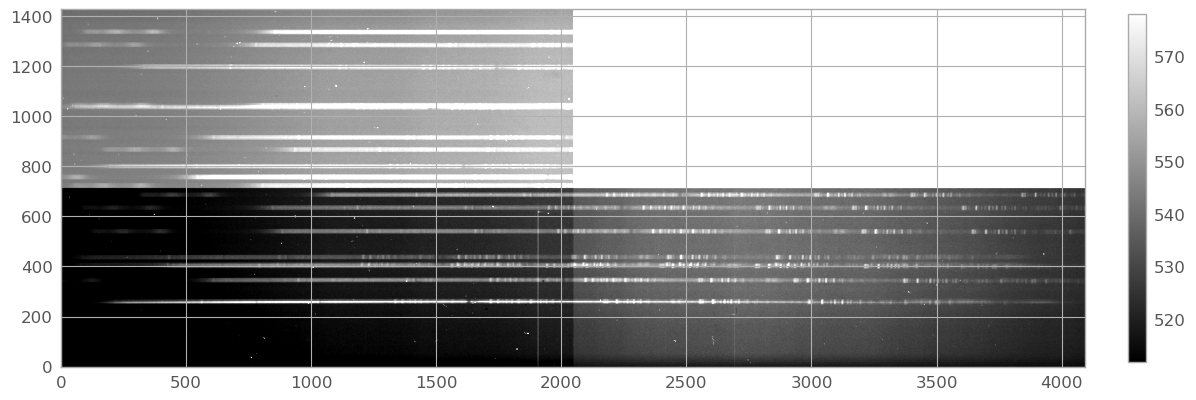

In [12]:
# display setting the limits for the gray scale
median = np.median(spectra)
stddev = np.std(spectra)
z0 = median-stddev
z1 = median+stddev
print(spectra.shape)
SAMOS.display_image(spectra,zmin=z0,zmax=z1)

## FLATS AND BIAS


INFO: Iteration 1: Found 627 cosmic-ray pixels, Total: 627 [lacosmic.core]
INFO: Iteration 2: Found 119 cosmic-ray pixels, Total: 746 [lacosmic.core]
INFO: Iteration 3: Found 34 cosmic-ray pixels, Total: 780 [lacosmic.core]
INFO: Iteration 4: Found 12 cosmic-ray pixels, Total: 792 [lacosmic.core]


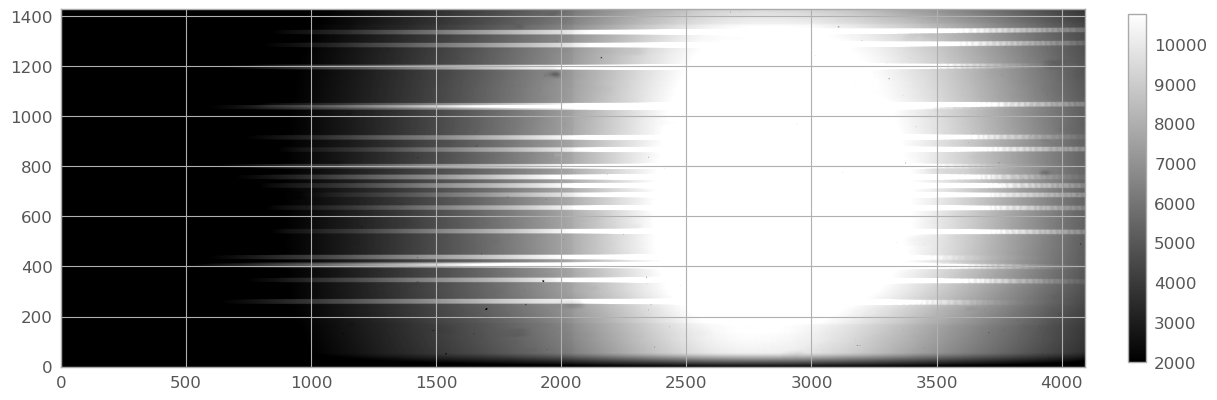

In [14]:
#SET THE FILE NAMES
File_type = "FLAT"
File_NR = '028'
file1  = os.path.join(data_directory_17,'target.'+File_NR+'.fits')
File_NR = '029'
file2  = os.path.join(data_directory_17,'calibration.'+File_NR+'.fits')

#SECOND STEP: READ AND AVERAGE
hdu = SAMOS.read_SAMI_mosaic(file1)
flat1_data = hdu.data
hdu.data = flat1_data

hdu1 = SAMOS.read_SAMI_mosaic(file2)
flat2_data = hdu1.data
hdu1.data = flat2_data
flat = ( flat1_data+flat2_data ) / 2

#SAVE
hdul = fits.HDUList([hdu]) ; hdul.writeto(File_type+'.fits',overwrite=True)

#correct for cosmic rays
flat = SAMOS.CR_correct(flat)

#DISPLAY
median = np.median(flat)
stddev = np.std(flat)
z0 = median-stddev
z1 = median+stddev

SAMOS.display_image(flat,zmin=z0,zmax=z1)

## Now the BIAS frames

INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]


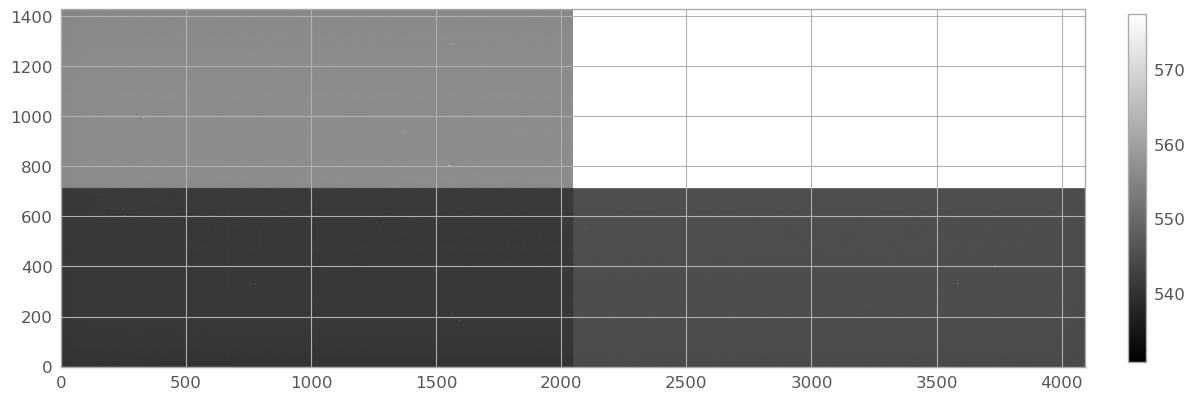

In [16]:
#FIRST STEP: SET THE FILE NAMES
File_type = "BIAS"

File_NR = ['055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074']
biases = np.zeros( (len(File_NR),1428,4094) )
for i in range(len(File_NR)):
    file = os.path.join(data_directory_16,'bias.'+File_NR[i]+'.fits')
    hdu = SAMOS.read_SAMI_mosaic(file)
    biases[i,:,:] = hdu.data
bias = biases.sum(axis=0)/len(File_NR)
bias.shape

#SAVE
hdul = fits.HDUList([hdu]) ; hdul.writeto(File_type+'.fits',overwrite=True)

#correct for cosmic rays
bias = SAMOS.CR_correct(bias)

#DISPLAY
median = np.median(bias)
stddev = np.std(bias)
z0 = median-stddev
z1 = median+stddev

SAMOS.display_image(bias,zmin=z0,zmax=z1)

## SUBTRACT THE BIAS FROM THE FLAT

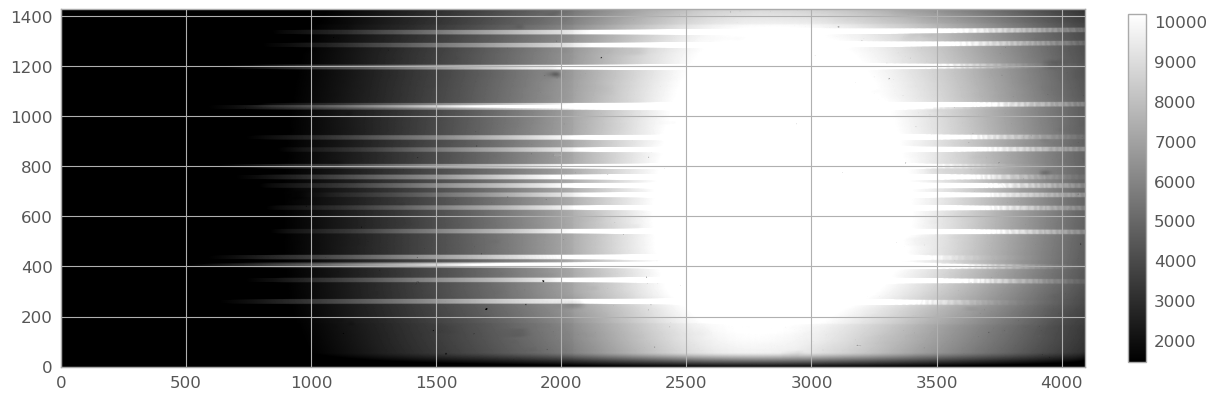

In [18]:
flat_bias = flat - bias

#DISPLAY
median = np.median(flat_bias)
stddev = np.std(flat_bias)
z0 = median-stddev
z1 = median+stddev

SAMOS.display_image(flat_bias,zmin=z0,zmax=z1)

## SUBTRACT THE BIAS FROM THE SPECTRA

-15.912818659015194
-0.48718134098489685


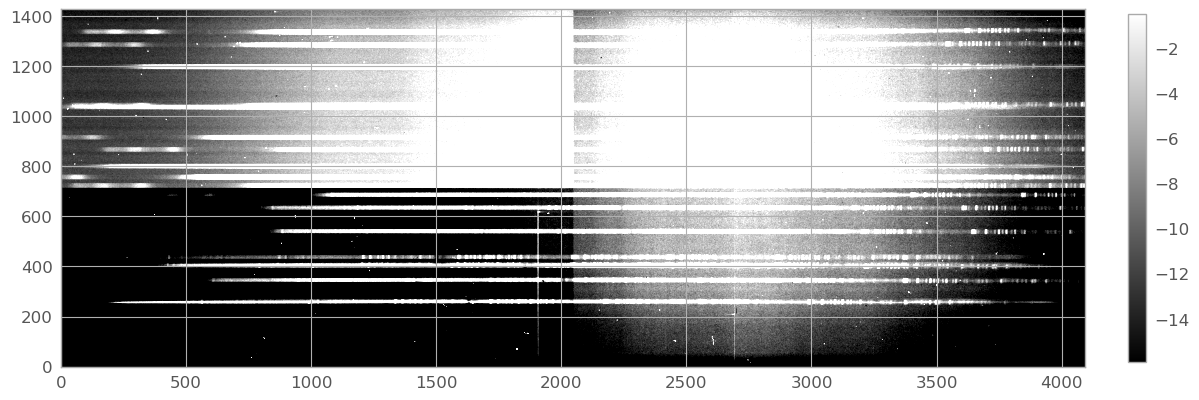

In [20]:
spectra_bias = spectra - bias

#DISPLAY
median = np.median(spectra_bias)
stddev = np.std(spectra_bias)
z0 = median-stddev/2  ; print(z0)
z1 = median+stddev/2  ; print(z1)

SAMOS.display_image(spectra_bias,zmin=z0,zmax=z1)

### There is clearly a problem with the bias, taken on a different night. 
### Also the quartz with all DMD open was taken on the previous night and does not subtract nicely. 
### This makes finding the traces difficult. 

4094
4094 1428
5.0 0.0 5.0 0.0


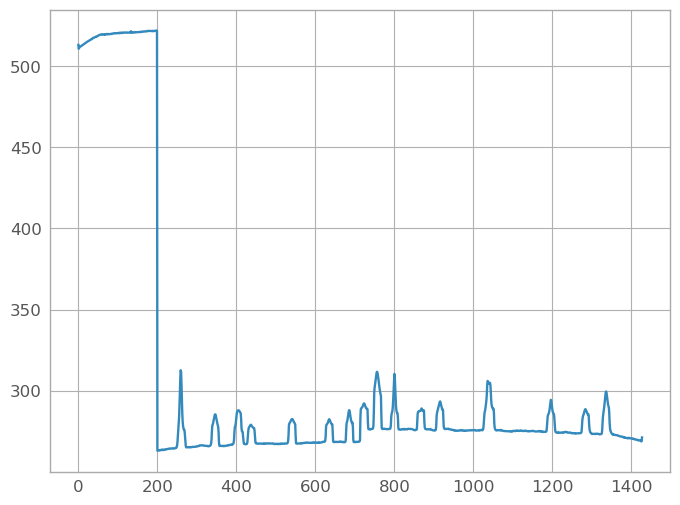

In [22]:
#should we ignore the bias and corect the spectra with their own "bias"
dx = spectra.shape[1] ; print(dx)
dy = spectra.shape[0]
print(dx,dy)
dy2=int(dy/2)
dx2=int(dx/2)

spectra_selfbias = copy.deepcopy(spectra)
spectra_selfbias[200:dy2,:dx2] = spectra[200:dy2,:dx2] - np.median(spectra[200:dy2,:dx2]) 
spectra_selfbias[dy2:,dx2:] = spectra[dy2:,dx2:] - np.median(spectra[dy2:,dx2:]) 
spectra_selfbias[200:dy2,:dx2] = spectra[200:dy2,:dx2] - np.median(spectra[200:dy2,:dx2]) 
spectra_selfbias[dy2:,dx2:] = spectra[dy2:,dx2:] - np.median(spectra[dy2:,dx2:])
print(np.median(spectra_selfbias[:dy2,:dx2]), np.median(spectra_selfbias[dy2:,dx2:]), np.median(spectra_selfbias[:dy2,:dx2]), np.median(spectra_selfbias[dy2:,dx2:]))
s_sb = (spectra_selfbias).mean(axis=1)
plt.plot(s_sb)
plt.show()

## GO WITH ARC LAMP

/Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA/RUN2/SAMI/20241017/calibration.032.fits
INFO: Iteration 1: Found 37263 cosmic-ray pixels, Total: 37263 [lacosmic.core]
INFO: Iteration 2: Found 8640 cosmic-ray pixels, Total: 45903 [lacosmic.core]
INFO: Iteration 3: Found 2688 cosmic-ray pixels, Total: 48591 [lacosmic.core]
INFO: Iteration 4: Found 1366 cosmic-ray pixels, Total: 49957 [lacosmic.core]


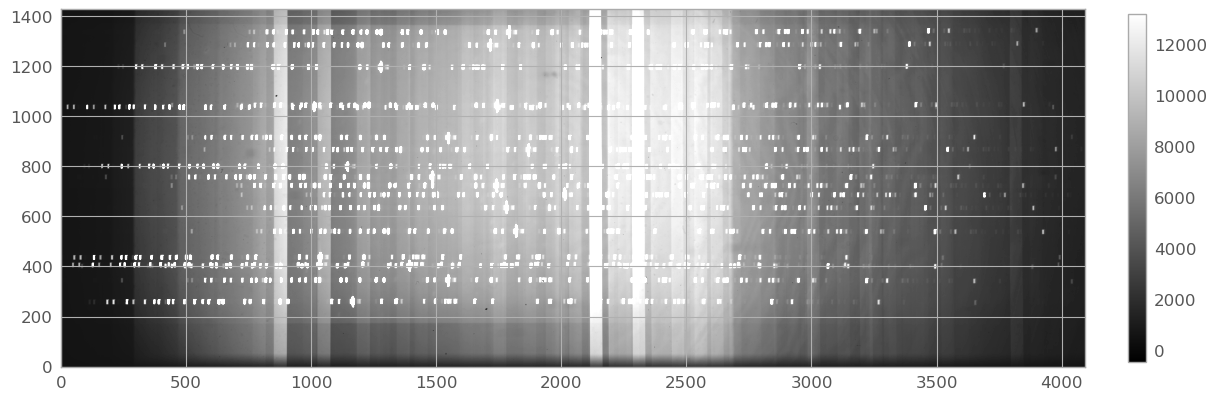

In [24]:
#FIRST STEP: SET THE FILE NAMES
File_type = "ARC"

File_NR = '032'
file  = os.path.join(data_directory_17,'calibration.'+File_NR+'.fits')
print(file)

hdu = SAMOS.read_SAMI_mosaic(file)
arc = hdu.data

#SAVE
hdul = fits.HDUList([hdu]) ; hdul.writeto(File_type+'.fits',overwrite=True)

#correct for cosmic rays
arc = SAMOS.CR_correct(arc)

#DISPLAY
median = np.median(arc)
stddev = np.std(arc)
z0 = median-stddev
z1 = median+stddev

SAMOS.display_image(arc,zmin=z0,zmax=z1)

### FOR THIS ARC WE HAVE ITS OWN "DARK", ILLUMINATION WITH NO DMD OPEN 

/Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA/RUN2/SAMI/20241017/calibration.035.fits
INFO: Iteration 1: Found 1355 cosmic-ray pixels, Total: 1355 [lacosmic.core]
INFO: Iteration 2: Found 135 cosmic-ray pixels, Total: 1490 [lacosmic.core]
INFO: Iteration 3: Found 32 cosmic-ray pixels, Total: 1522 [lacosmic.core]
INFO: Iteration 4: Found 6 cosmic-ray pixels, Total: 1528 [lacosmic.core]


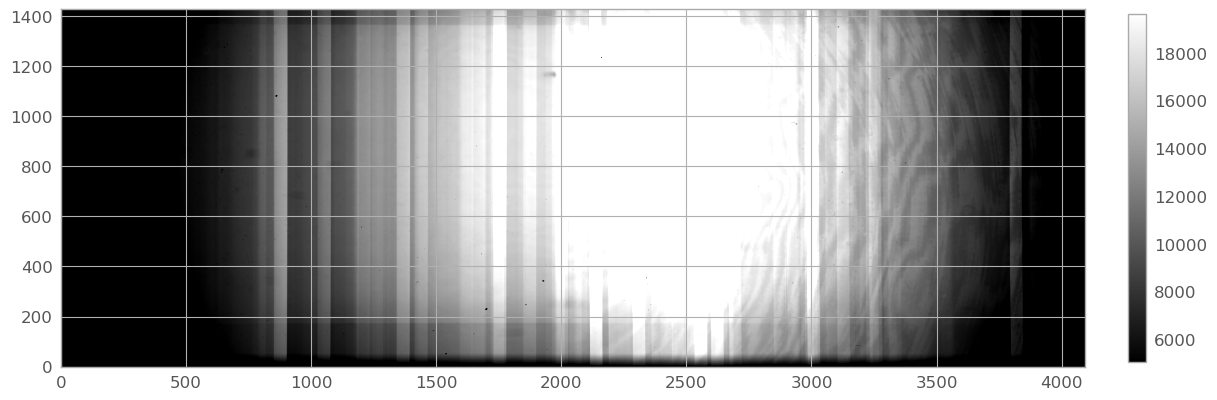

In [26]:
File_type = "ARC_noDMD"

File_NR = '035'
file  = os.path.join(data_directory_17,'calibration.'+File_NR+'.fits')
print(file)

hdu_noDMD = SAMOS.read_SAMI_mosaic(file)
arc_noDMD = hdu_noDMD.data
#SAVE
hdul = fits.HDUList([hdu_noDMD]) ; hdul.writeto(File_type+'.fits',overwrite=True)

#correct for cosmic rays
arc_noDMD = SAMOS.CR_correct(arc_noDMD)

#DISPLAY
median = np.median(arc_noDMD)
stddev = np.std(arc_noDMD)
z0 = median-stddev
z1 = median+stddev

SAMOS.display_image(arc_noDMD,zmin=z0,zmax=z1)

### THE SUBTRACION IS VERY GOOD

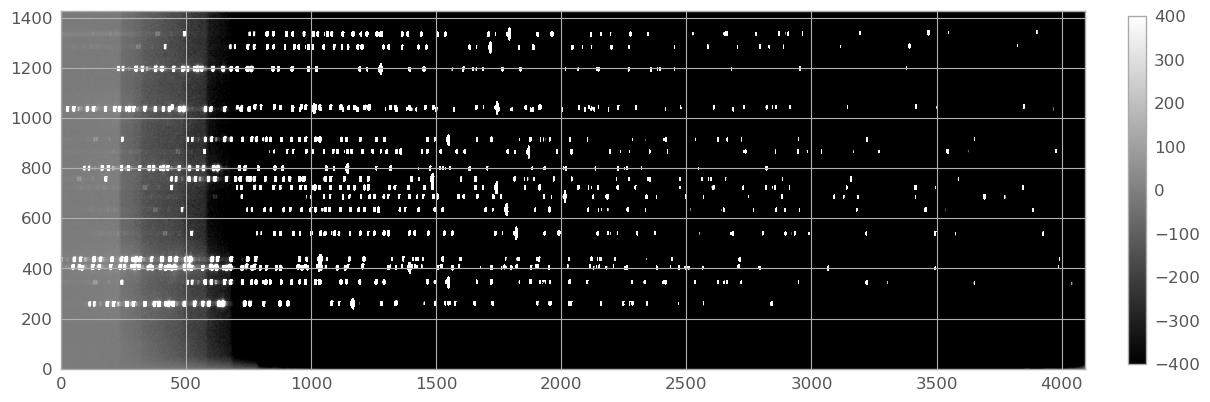

In [28]:
arc_good = arc-arc_noDMD
SAMOS.display_image(arc_good,zmin=-400,zmax=400)

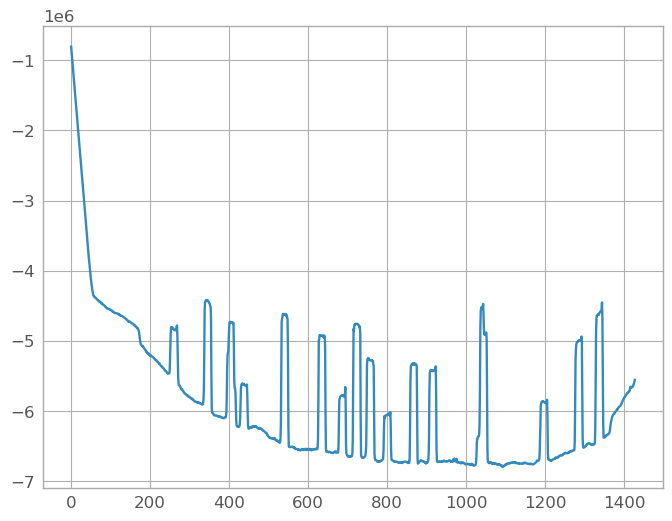

In [29]:
#Check the coadded rows
plt.plot(arc_good[:,2500:3000].sum(axis=1))

# Nicely sharp. Looks great. We can use the arc to find the traces!

# Find the traces

4094


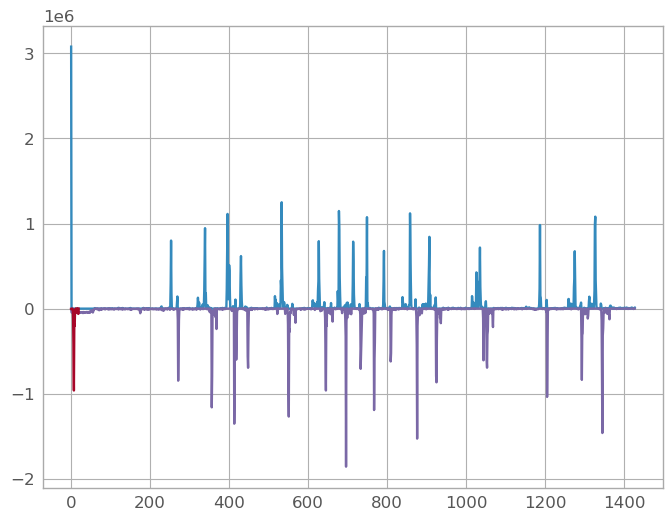

In [32]:
dx = arc_good.shape[1] ; print(dx)
dy = arc_good.shape[0]
mask = np.zeros((dy,dx))
cut = arc_good[:,1500:2000].sum(axis=1)
cut1 = np.roll(cut,+1)
diff=cut-cut1
diff_neg = copy.deepcopy(diff)
diff_neg[diff > 0] =0 
diff_pos = copy.deepcopy(diff)
diff_pos[diff < 0] = 0
#match = diff_pos * (-np.roll(diff_neg,-8))
plt.plot(diff_pos)#[620:640])
plt.plot(diff_neg)#[620:640])
plt.plot(np.roll(diff_neg,-18)[620:640])


plt.show()


### Find some peaks using the smoothing parameter.
fp = findpeaks(lookahead=1, interpolate=3) results = fp.fit(diff_pos)

In [34]:
peak_threshold = 4E5
v_slit_up, _ = find_peaks(diff_pos, distance=3,height=peak_threshold)
print(v_slit_up)
v_slit_down, _ = find_peaks(-diff_neg, distance=3,height=peak_threshold)
print(v_slit_down)


[ 253  339  396  400  430  533  627  678  714  749  792  858  907 1026
 1035 1187 1275 1327]
[ 271  356  413  418  448  551  645  696  733  767  809  876  925 1044
 1053 1205 1293 1345]


# ... there is no problem with the pairing of the edges.
# however there are slits too close to each other. Remove some entry...

In [36]:
to_be_removed = []
for i in range (1,len(v_slit_up)):
    #print(v_slit_up[i],v_slit_down[i])
    try:
        print(v_slit_up[i+1])
    except:
        continue
    if (v_slit_down[i] > v_slit_up[i+1]):
        print(v_slit_up[i],v_slit_down[i],"conflict! remove i =",i)
        to_be_removed.append(i)
    if (v_slit_down[i-1] > v_slit_up[i]):
        print(v_slit_up[i],v_slit_down[i],"conflict! remove i =",i)
        to_be_removed.append(i)
    else:    
        print(v_slit_up[i],v_slit_down[i])
print('to_be_removed = ',to_be_removed)
print(len(v_slit_up))
v_slit_up=np.delete(v_slit_up, to_be_removed,axis=0) 
v_slit_down=np.delete(v_slit_down, to_be_removed, axis=0)
print(len(v_slit_up))

print("\nCHECK:")
good_slits = []
for i in range (len(v_slit_up)):
    print(i,v_slit_up[i],v_slit_down[i])
    good_slits.append(i)

396
339 356
400
396 413 conflict! remove i = 2
396 413
430
400 418 conflict! remove i = 3
533
430 448
627
533 551
678
627 645
714
678 696
749
714 733
792
749 767
858
792 809
907
858 876
1026
907 925
1035
1026 1044 conflict! remove i = 13
1026 1044
1187
1035 1053 conflict! remove i = 14
1275
1187 1205
1327
1275 1293
to_be_removed =  [2, 3, 13, 14]
18
14

CHECK:
0 253 271
1 339 356
2 430 448
3 533 551
4 627 645
5 678 696
6 714 733
7 749 767
8 792 809
9 858 876
10 907 925
11 1187 1205
12 1275 1293
13 1327 1345


#v_slit_up=np.delete(v_slit_up, 1, axis=0)
print(v_slit_up[:,1], len(v_slit_up[:,1]))
slit_up = v_slit_up[:,1]

v_slit_down=np.delete(v_slit_down, 5, axis=0)
print(v_slit_down[:,1], len(v_slit_down[:,1]))
slit_down = v_slit_down[:,1]
plt.scatter(v_slit_up[:,1],v_slit_down[:,1],c='blue')

## Good. We can now define the slits

In [39]:
slits=[]
for i in range(len(v_slit_up)):
    slits.append([v_slit_up[i],v_slit_down[i]])
    print("slit",i,"with dy =", v_slit_down[i]-v_slit_up[i])
print("that we can call using e.g. slits[5]:",slits[5])


slit 0 with dy = 18
slit 1 with dy = 17
slit 2 with dy = 18
slit 3 with dy = 18
slit 4 with dy = 18
slit 5 with dy = 18
slit 6 with dy = 19
slit 7 with dy = 18
slit 8 with dy = 17
slit 9 with dy = 18
slit 10 with dy = 18
slit 11 with dy = 18
slit 12 with dy = 18
slit 13 with dy = 18
that we can call using e.g. slits[5]: [678, 696]


## BETTER: we also set the limits of the adjacent field edges:

In [41]:
slits=[]
for i in range(len(v_slit_up)):
    #print([slit_up[i],slit_down[i]])
    if i ==0:
        s0 = v_slit_up[i]-12
    else:    
        s0 = np.max([v_slit_down[i-1],v_slit_up[i]-12])
    if  i == len(v_slit_down)-1:
        s1 = v_slit_down[i]+12
    else:
        s1 = np.min([v_slit_up[i+1],v_slit_down[i]+12])
#    print([s0,slit_up[i],slit_down[i],s1])   
    slits.append([s0,v_slit_up[i],v_slit_down[i],s1])
    print("slit",i,"with dy =",s1-s0)

print("So the slit[0] is:",slits[2])

slit 0 with dy = 42
slit 1 with dy = 41
slit 2 with dy = 42
slit 3 with dy = 42
slit 4 with dy = 42
slit 5 with dy = 42
slit 6 with dy = 43
slit 7 with dy = 42
slit 8 with dy = 41
slit 9 with dy = 42
slit 10 with dy = 42
slit 11 with dy = 42
slit 12 with dy = 42
slit 13 with dy = 42
So the slit[0] is: [418, 430, 448, 460]


## so basically we have found the traces

## FROM THIS POINT ON ONE COULD PROCEED WITH A LOOP.
## HERE WE DEMONSTRATE PROCEDURE FOR A SINGLE SLIT Nr 10

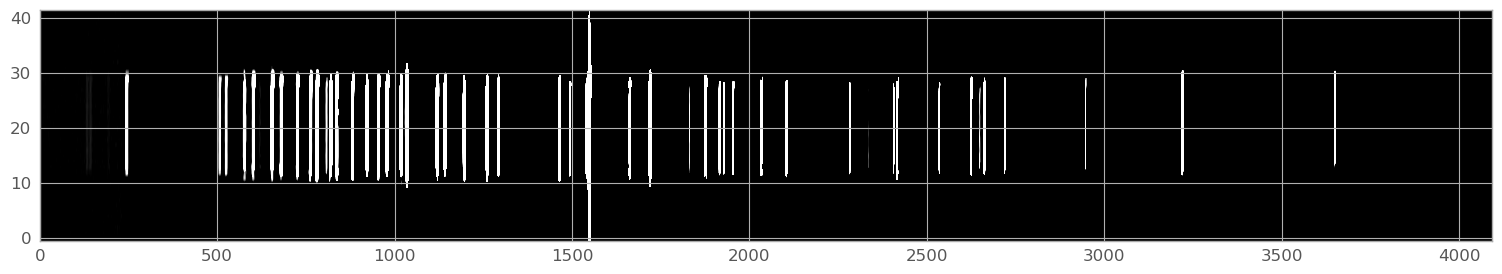

In [43]:
i_slit=10
#arc_good = arc-arc_noDMD
#plt.imshow(image, origin='lower', cmap='gray',vmin=zmin, vmax=zmax)

plt.figure(figsize=(20,3))
plt.imshow(arc_good[slits[i_slit][0]:slits[i_slit][3],:], origin='lower', cmap='gray',vmin=0, vmax=1000,aspect='15.5')
#plt.gca().set_aspect(0.5)
plt.show()

# Plot all slits

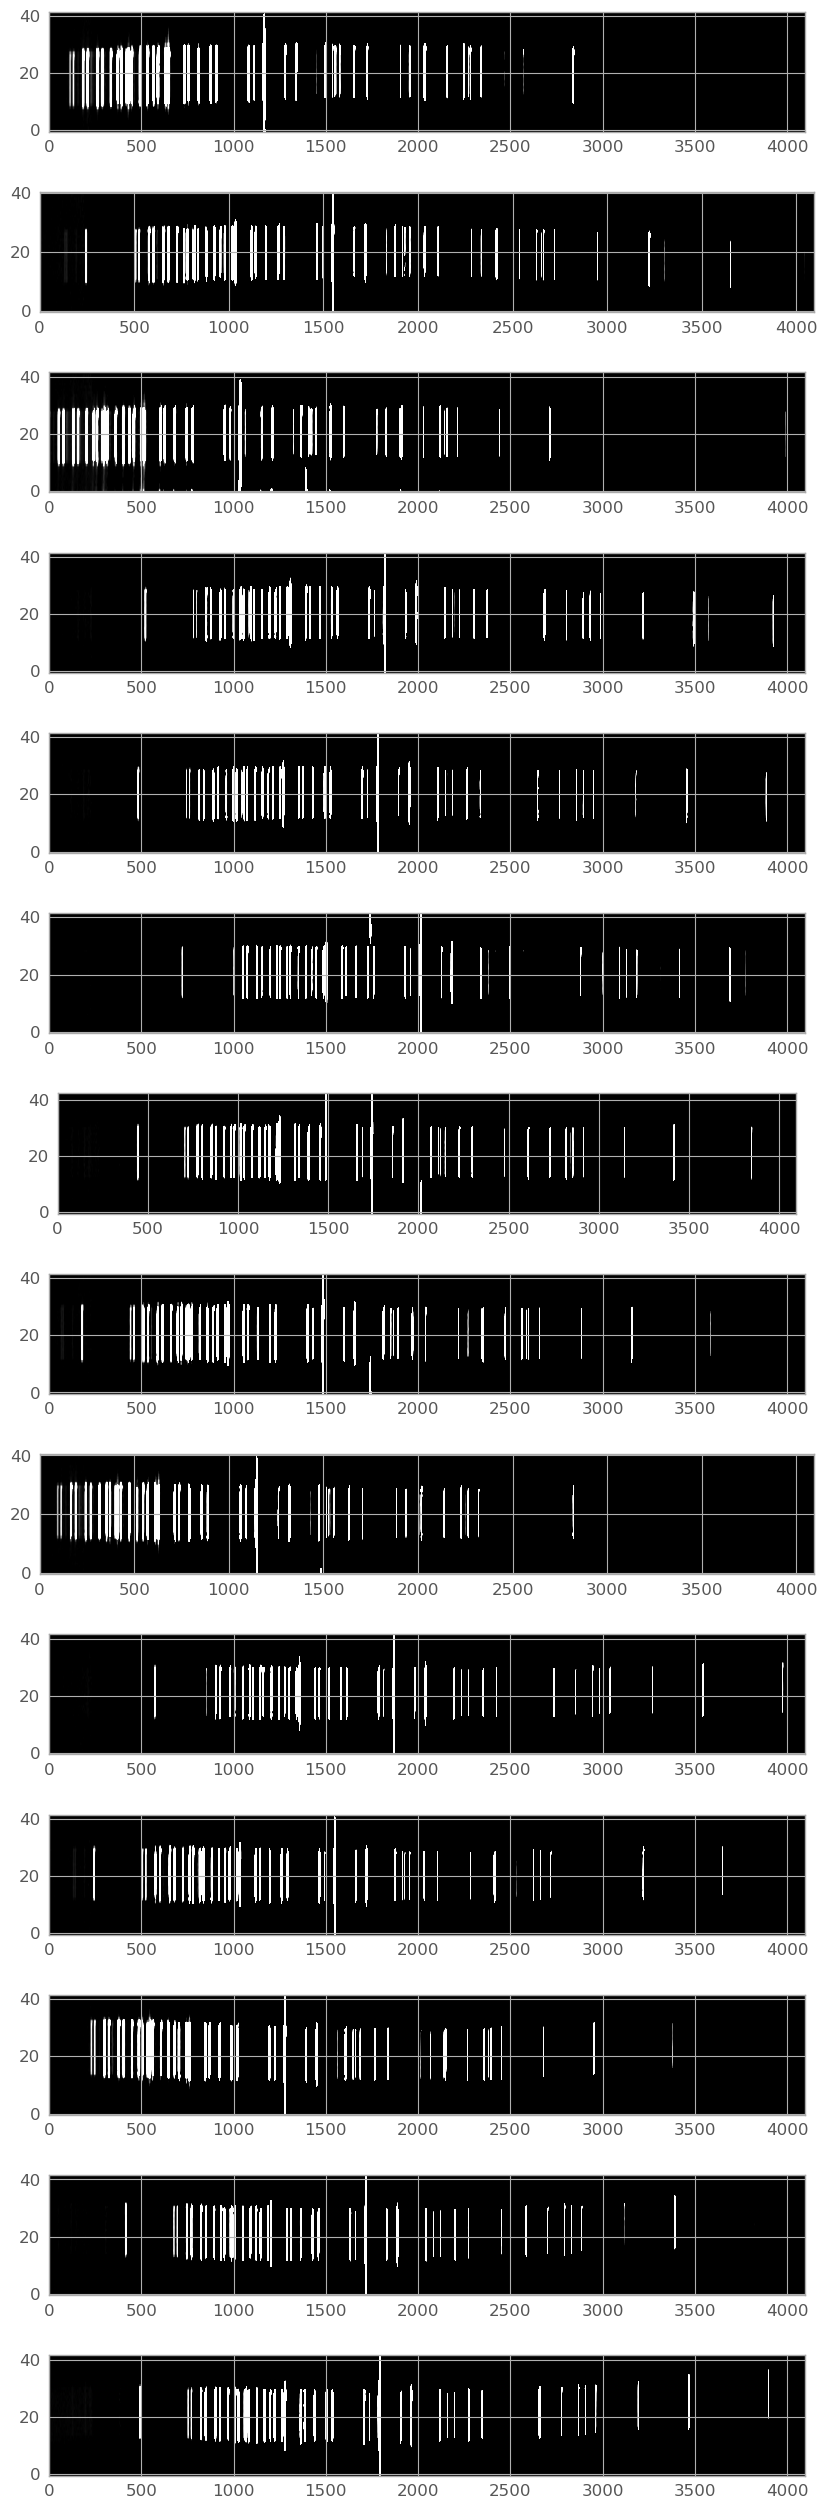

In [45]:
f, axarr = plt.subplots(len(slits),figsize=(20, 32))
#axarr.figure(figsize=(20,30))
for i_s in range(len(slits)):
    axarr[i_s].imshow(arc_good[slits[i_s][0]:slits[i_s][3],:], origin='lower', cmap='gray',vmin=0, vmax=1000,aspect='15.5')
plt.show()

# Repeat with the flats

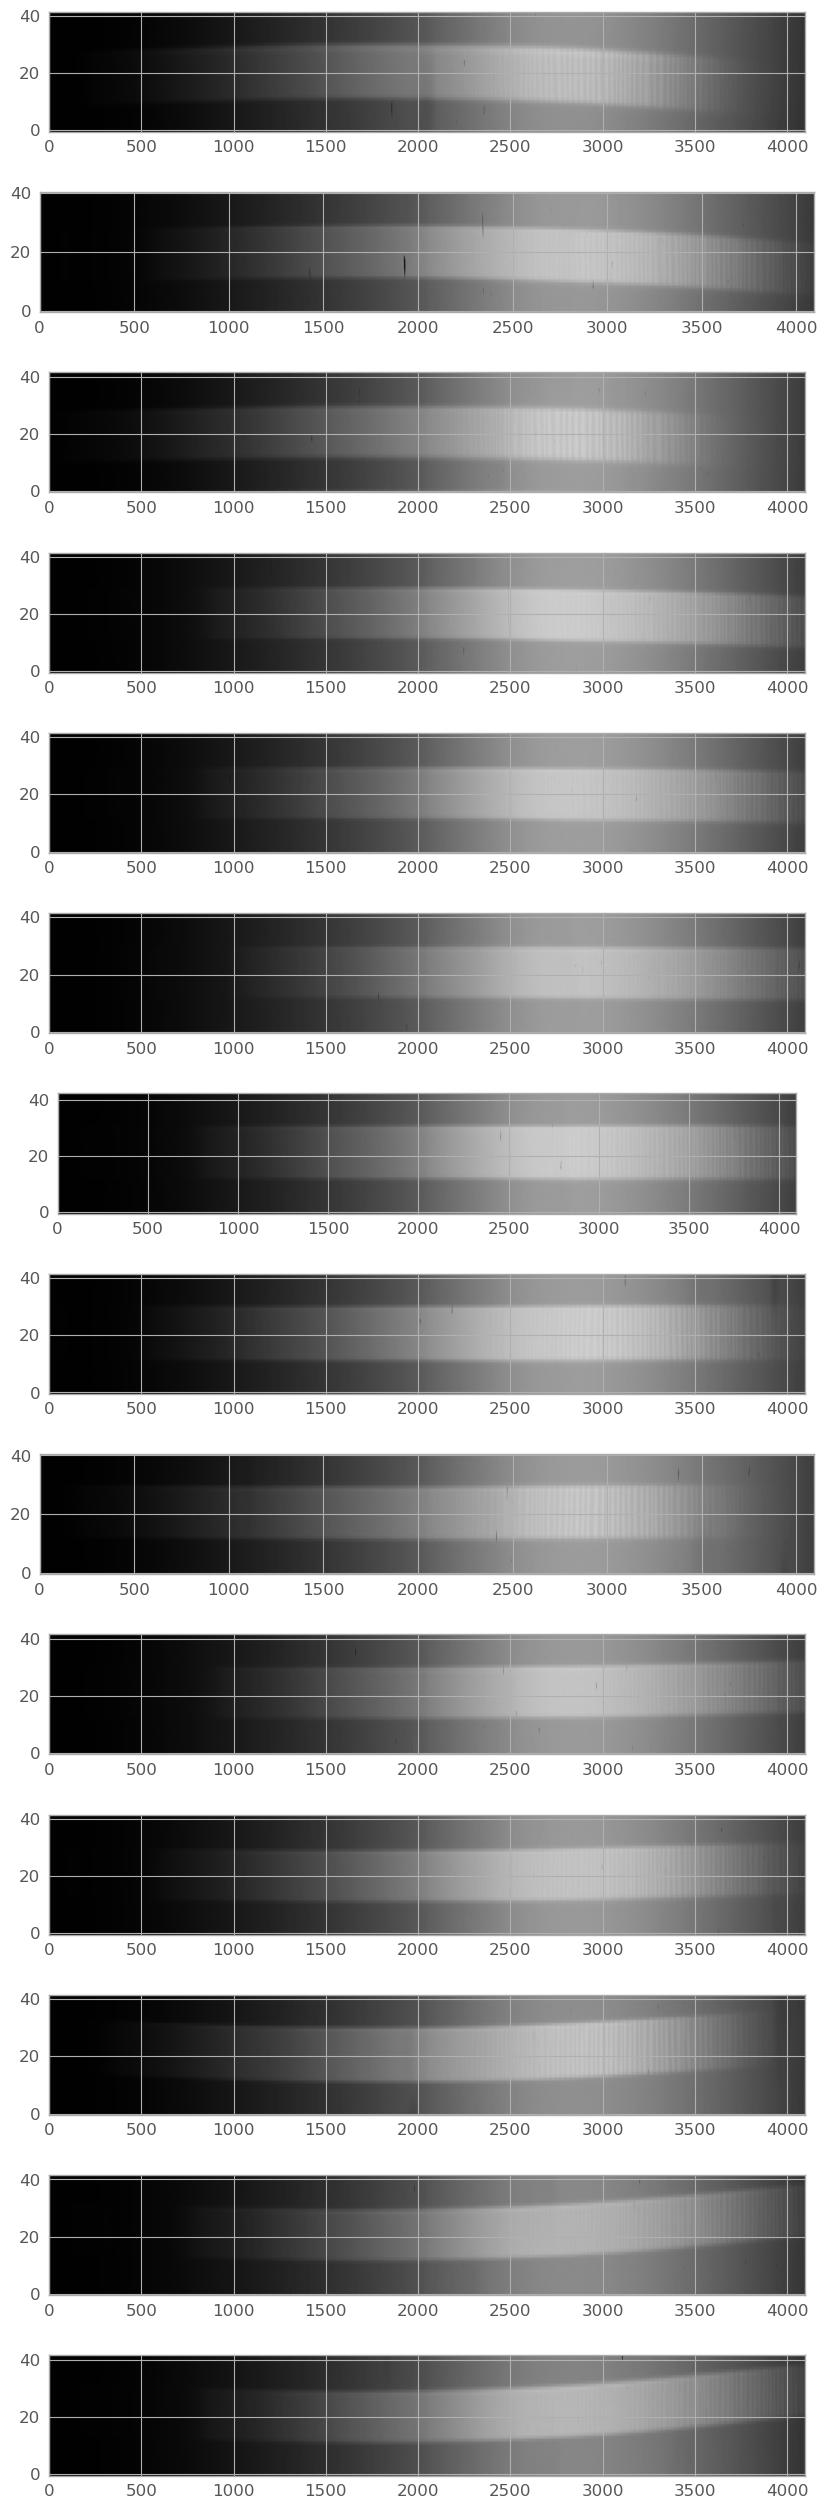

In [47]:
f, axarr = plt.subplots(len(slits),figsize=(20, 32))
#axarr.figure(figsize=(20,30))
for i_s in range(len(slits)):
    axarr[i_s].imshow(flat_bias[slits[i_s][0]:slits[i_s][3],:], origin='lower', cmap='gray',vmin=-100, vmax=20000,aspect='15.5')
plt.show()

# Repeat with spectra

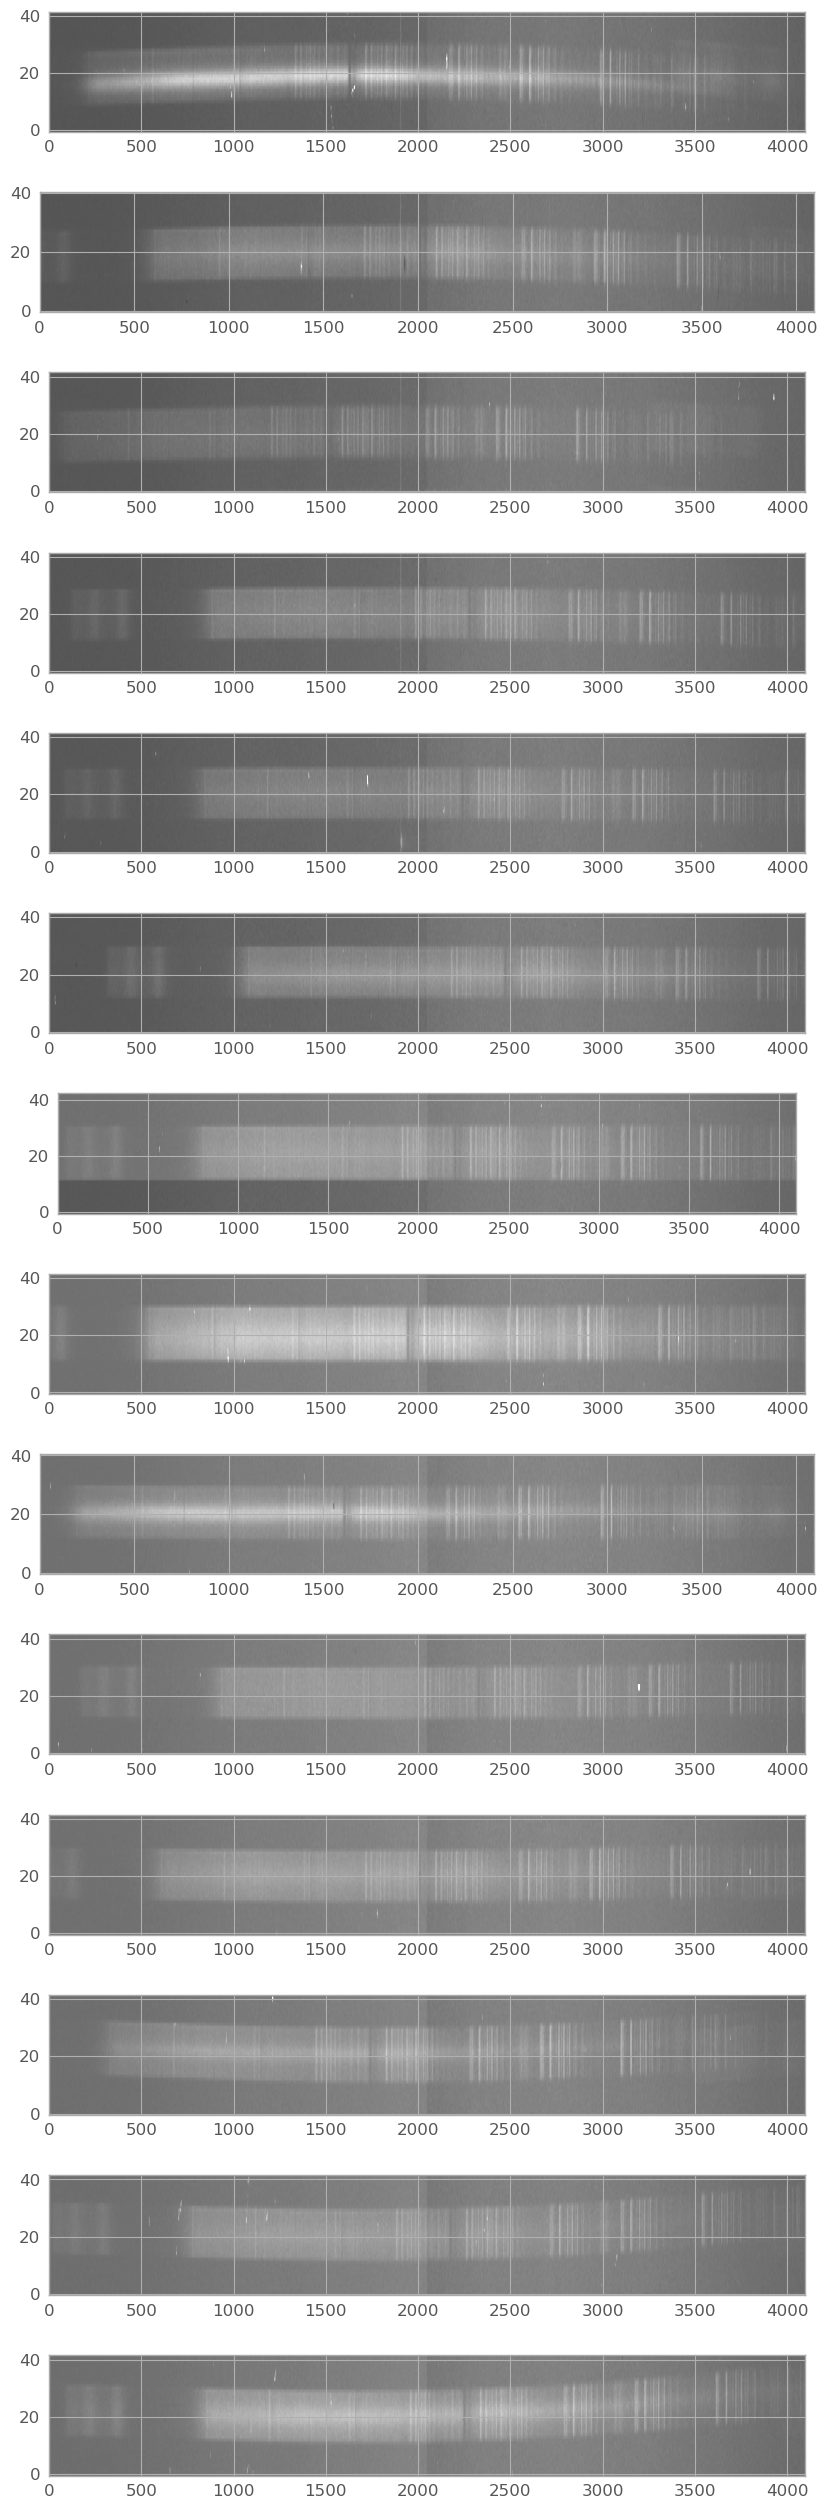

In [49]:
f, axarr = plt.subplots(len(slits),figsize=(20, 32))
#axarr.figure(figsize=(20,30))
for i_s in range(len(slits)):
    axarr[i_s].imshow(spectra_bias[slits[i_s][0]:slits[i_s][3],:], origin='lower', cmap='gray',vmin=-100, vmax=100,aspect='15.5')
plt.show()

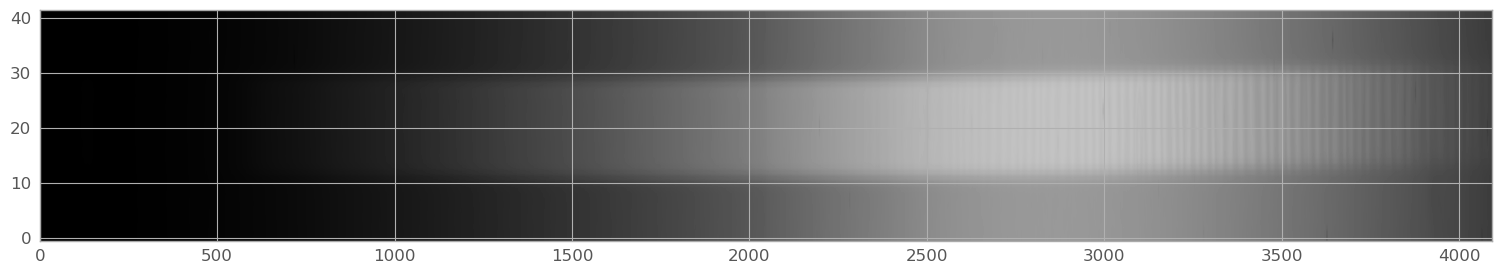

In [50]:
#first we inspect the situation

flat_bias_blur = cv2.GaussianBlur(flat_bias,(5,5), sigmaX=0, sigmaY=0)
plt.figure(figsize=(20,3))
slit = flat_bias_blur[slits[i_slit][0]:slits[i_slit][3],:]
plt.imshow(slit, origin='lower', cmap='gray',vmin=0, vmax=20000,aspect='15.5')
#plt.gca().set_aspect(0.5)
plt.show()


# Find the tilt of the spectra

In [52]:
#first we define a function that finds the edges of a 1-d vector
def find_edges(data):
    threshold = (max(data)-min(data))/5  
    gradient = [data[i] - data[i-1] for i in range(1, len(data))]
    edges = [i for i, grad in enumerate(gradient) if abs(grad) > threshold]
    return edges

220


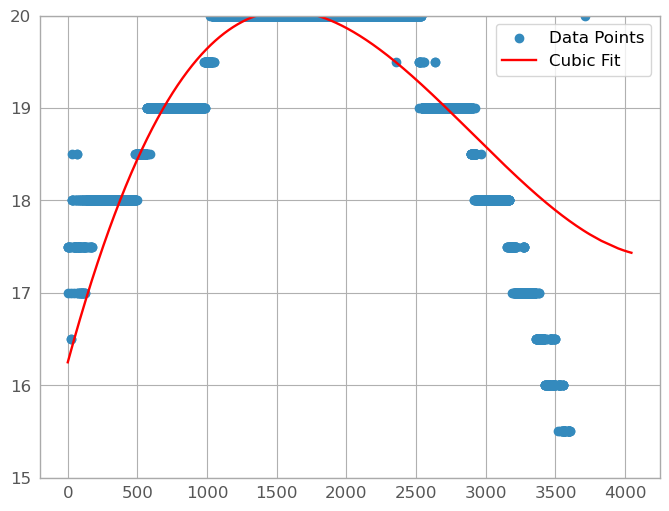

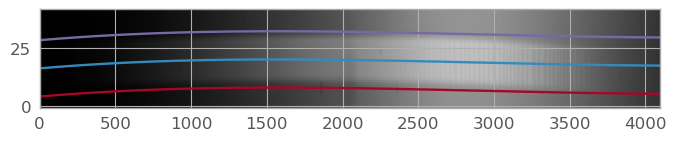

In [53]:
#then the logic is to scan the rectangular area in the x direction, 
#looking for the edges of each column; 
#if there is no edge, skip the column
#if there are multiple edges, pick the maximum and minimum value
#the procedure returns the central value between the extreme edges, i.e. the center of the trace.

i_slit=0
xpix=[]
yctr=[]
i_flat=flat_bias_blur[slits[i_slit][0]:slits[i_slit][3],:]
for ix in range(dx):    
    v = i_flat[:,ix]
    #threshold = (max(v)-min(v))/5  
    edges=find_edges(v)
    if len(edges) == 0:
        continue
    e0 = edges[0]
    e1 = edges[-1]
    #print(i,e0,e1,np.mean([e0,e1]))
    xpix.append(ix)
    yctr.append(np.mean([e0,e1]))

ilen = 0
for ix in range(dx-100):
    if np.std(yctr[ix:ix+100]) == 0:
        imin=ix
        ilen+=1
        if ilen == 50:
            break
print(imin)
#print(np.std(yctr[i:i+100]))
    
#next we fit a polynomial, 3rd degree, to the array of centers
coefficients = np.polyfit(xpix[imin:], yctr[imin:], 3)
# Create polynomial function
p = np.poly1d(coefficients)

#plot to check....
plt.ylim(15,20)
plt.scatter(xpix, yctr, label='Data Points')
plt.plot(xpix, p(xpix), label='Cubic Fit', color='red')
plt.legend()
plt.show()
 

# but basically we have the trace.
#Show it with an overlay on the image
fig, ax = plt.subplots()
# Display the image
ax.imshow(flat_bias_blur[slits[i_slit][0]:slits[i_slit][3],:], origin='lower', cmap='gray',vmin=0, vmax=20000,aspect='15.5')
#Display the center trace
x=np.arange(dx)
plt.plot(x, p(x))
#and the edges
below = slits[i_slit][1] - slits[i_slit][0]
above = slits[i_slit][3] - slits[i_slit][2]
plt.plot(x, p(x)+above)
plt.plot(x, p(x)-below)
plt.show()
# Plot the vector

#display_imageslits[i_slit][1]#:i_slit[0][1],1000:1100]

## CREATE THE TWO BINARY MASKS: Illuminated vs. non-illuminated

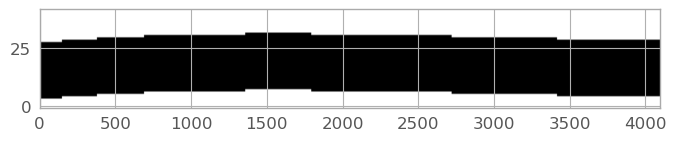

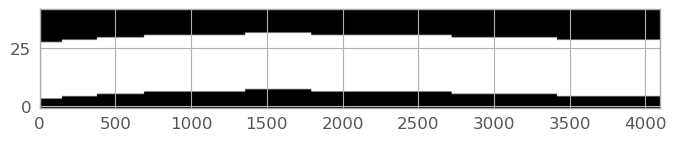

In [55]:
mask_in = i_flat*0
mask_out = i_flat*0
for ix in range(dx):
    mask_out[0:int(p(ix)-below),ix]  = 1
    mask_out[int(p(ix)+above):,ix]  = 1
plt.imshow(mask_out, origin='lower', cmap='gray',aspect='15.5') 
plt.show()

mask_in = 1-mask_out
plt.imshow(mask_in, origin='lower', cmap='gray',aspect='15.5') 
plt.show()

# Extract the flats

(42, 4094)


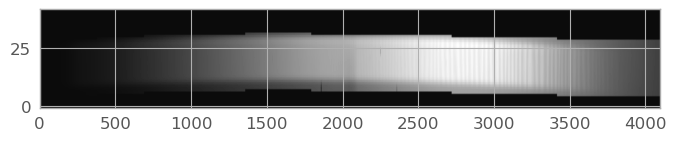

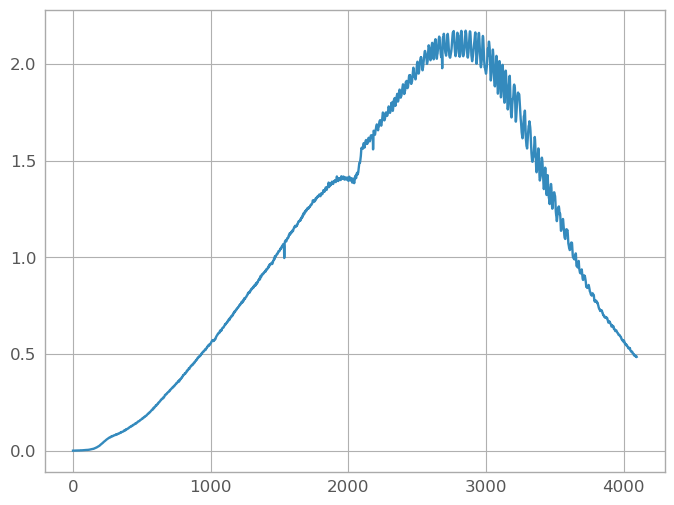

(42, 4094)


In [57]:
i_flat_bck = i_flat * mask_out
i_flat_slit = i_flat * mask_in
print(i_flat_slit.shape)
for ix in range(dx):
    i_flat_slit[:,ix] = i_flat_slit[:,ix] - np.mean(i_flat_bck[:,ix])
i_flat_slit *= mask_in   
i_flat_slit = i_flat_slit/np.mean(i_flat_slit[i_flat_slit != 0])
plt.imshow(i_flat_slit, origin='lower', cmap='gray',aspect='15.5') 
plt.show()
plt.plot(i_flat_slit[20,:])
plt.show()
print(i_flat_slit.shape)

(42, 4094)
(42, 4094) (42, 4094)


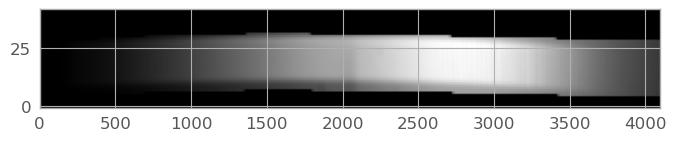

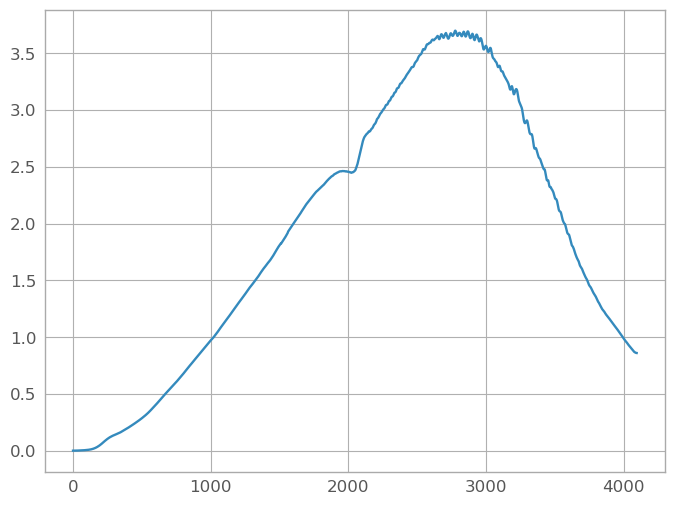

(42, 4094)


In [58]:
# Creating a kernel for numpy 
kernel2 = np.ones((1, 50), np.float32)/50
print(i_flat_slit.shape)  
# Applying the filter 
i_flat_slit_smooth = cv2.filter2D(src=i_flat_slit, ddepth=-1, kernel=kernel2) 
print(i_flat_slit.shape,i_flat_slit_smooth.shape)

#flat_slit_smooth *= mask_in   
i_flat_slit_smooth = i_flat_slit_smooth/np.mean(i_flat_slit_smooth[i_flat_slit_smooth != 0])
i_flat_slit_smooth *= mask_in
plt.imshow(i_flat_slit_smooth, origin='lower', cmap='gray',aspect='15.5') 
plt.show()
plt.plot(i_flat_slit_smooth[20,:])
plt.show()
print(i_flat_slit_smooth.shape)

### Flat field the image

(42, 4094)


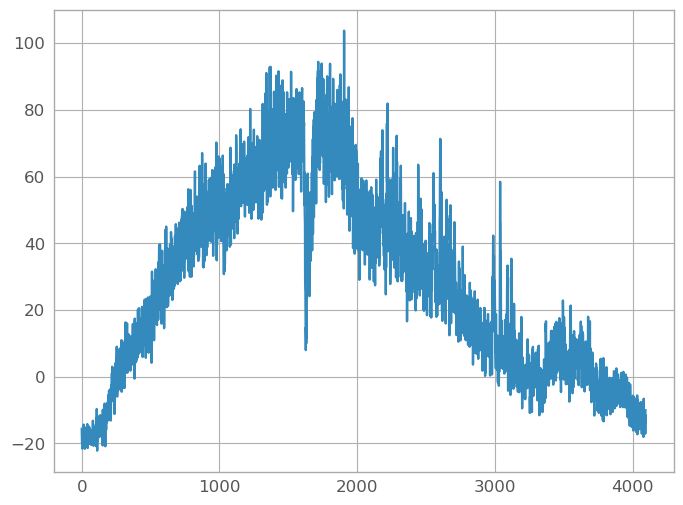

/var/folders/2z/85ggsfbj039grrtmzks24jy80004yn/T/ipykernel_80536/2257930782.py:10: RuntimeWarning: invalid value encountered in divide
  i_spectra_slit_ff = i_spectra_slit / i_flat_slit_smooth


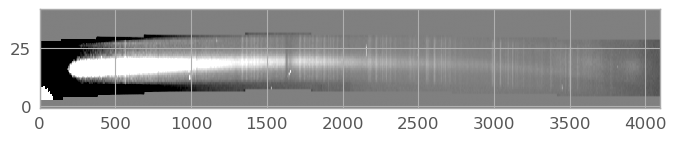

In [60]:
i_spectra_slit  = spectra_bias[slits[i_slit][0]:slits[i_slit][3],:] * mask_in
i_spectra_bck = spectra_bias[slits[i_slit][0]:slits[i_slit][3],:] * mask_out
for ix in range(dx):
    i_spectra_slit[:,ix] = i_spectra_slit[:,ix] - np.mean(i_spectra_bck[:,ix])
i_spectra_slit *= mask_in   
print(i_spectra_slit.shape)

plt.plot(i_spectra_slit[20,:])
plt.show()
i_spectra_slit_ff = i_spectra_slit / i_flat_slit_smooth
i_spectra_slit_ff = np.nan_to_num(i_spectra_slit_ff,posinf=0, neginf=0)
#print(spectra_slit_ff)
plt.imshow(i_spectra_slit_ff, origin='lower', cmap='gray',vmin=-50, vmax=50,aspect='15.5') 
plt.show()

# RECTIFY THE SPECTRUM

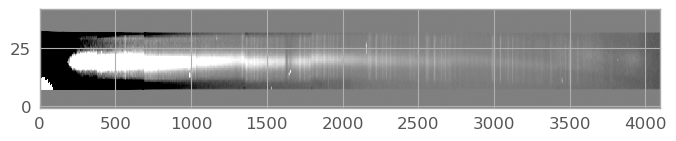

In [62]:
i_spectra_slit_ff_rect = i_spectra_slit_ff * 0
for ix in range(dx):
    i_spectra_slit_ff_rect[:,ix] = np.roll(i_spectra_slit_ff[:,ix],-int(p(ix))+20)
plt.imshow(i_spectra_slit_ff_rect,origin='lower', cmap='gray',vmin=-50, vmax=50,aspect='15.5') 
plt.show()

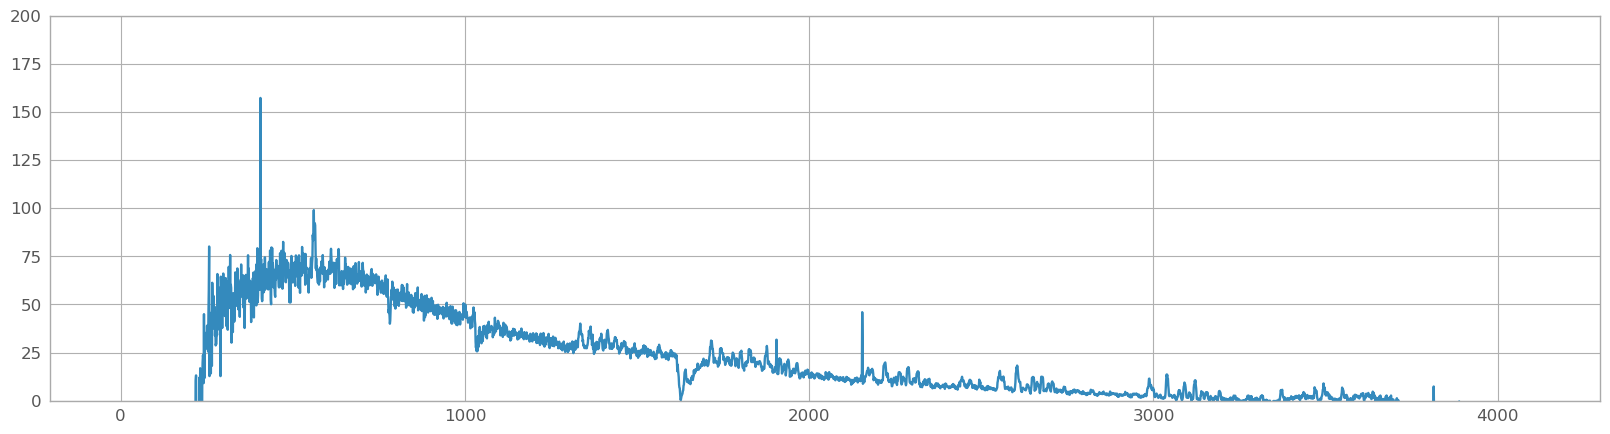

In [63]:
i_spectrum_1d = i_spectra_slit_ff[17:25,:].mean(axis=0)
plt.figure(figsize=(20,5))
plt.ylim([0,200])
plt.plot(i_spectrum_1d) 
plt.show()


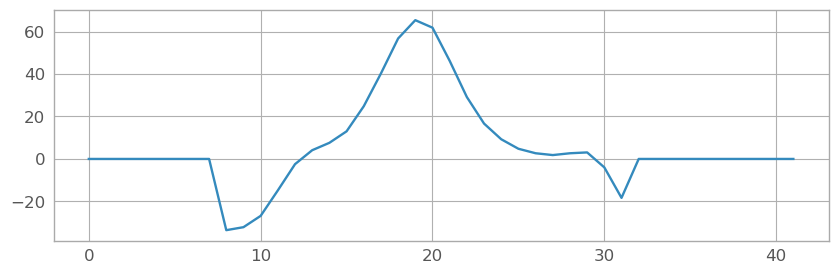

In [64]:
spectrum_1d = i_spectra_slit_ff_rect[:,800:1500].mean(axis=1)
plt.figure(figsize=(10,3))
#plt.ylim([0,200])
plt.plot(spectrum_1d) 
plt.show()


# SUBTRACT SKY

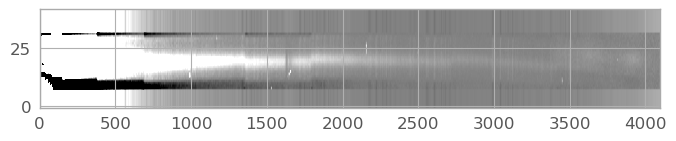

In [66]:
i_spectra_slit_ff_rect_OH = i_spectra_slit_ff_rect 
for ix in range(dx):#2000,2001):
    #print(i)
    v=i_spectra_slit_ff_rect[:,ix]
    v=v[v != 0]
    #print(v)
    vs = np.sort(v)
    #print(vs)
    mmm = np.median(vs[3:7])
    #print(mmm)
    i_spectra_slit_ff_rect_OH[:,ix] = i_spectra_slit_ff_rect[:,ix] - mmm
    #print(spectra_slit_ff_rect_OH[:,i])
plt.imshow(i_spectra_slit_ff_rect_OH,origin='lower', cmap='gray',vmin=-50, vmax=50,aspect='15.5') 
plt.show()

### Look at the 1-d spectrum


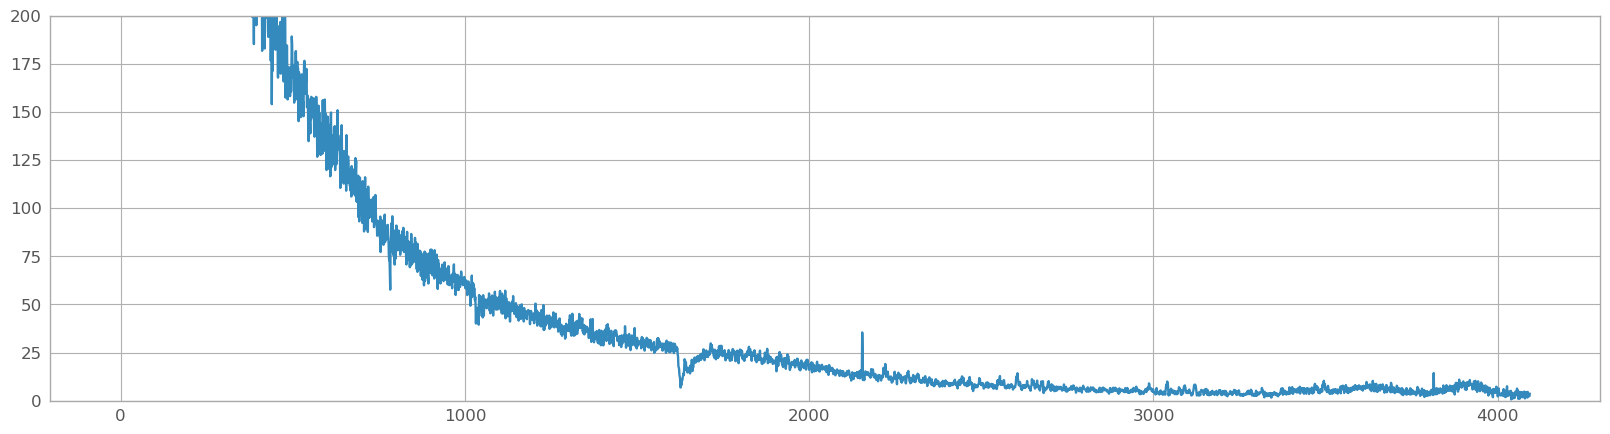

In [68]:
i_spectrum_1d = i_spectra_slit_ff_rect_OH[17:25,:].mean(axis=0)
plt.figure(figsize=(20,5))
plt.ylim([0,200])
plt.plot(i_spectrum_1d) 
plt.show()


### LINE CALIBRATION - TO RUN SET i_slit = 10 above (randomly selected...)

In [70]:
i_slit = 1 #make sure this has been set also above

arc_good_slit  = arc_good[slits[i_slit][0]:slits[i_slit][3],:] * mask_in
arc_good_bck = arc_good[slits[i_slit][0]:slits[i_slit][3],:] * mask_out
plt.imshow(1arc_good_slit, origin='lower', cmap='gray',vmin=-50, vmax=150,aspect='15.5') 
plt.show()

arc_good_rect = arc_good_slit * 0
for i in range(dx):
    arc_good_rect[:,i] = np.roll(arc_good_slit[:,i],-int(p(i))+20)
plt.imshow(arc_good_rect,origin='lower', cmap='gray',vmin=-50, vmax=150,aspect='15.5') 
plt.show()

plt.figure(figsize=(20,5))
#plt.yscale('log')
plt.ylim([10,4e4])
plt.plot(arc_good_rect.mean(axis=0))


#find the lines
#from scipy.signal import find_peaks 
import findpeaks
fp = findpeaks.findpeaks(lookahead=1)
#results = fp.fit(vector)
lines_df = fp.fit(arc_good_rect.mean(axis=0))
lines= lines_df['df'][ (lines_df['df']['peak'] == True)] 
lll = lines[lines['y'] > 100 ]
print(lll)
lll_np=lll.to_numpy()
xxx = lll.x.to_numpy()
yyy = lll.y.to_numpy()
#v_slit_up=np.delete(v_slit_up, 16, axis=0)
#print(lll_np[:,1], len(lll_np[:,1]))
#print(lines)
ax = fig.add_subplot(1, 1, 1)
plt.scatter(xxx,yyy)
for i in range(len(xxx)):
    plt.text(xxx[i], yyy[i]*1.2, str(xxx[i]), fontsize = 12)
plt.show()




SyntaxError: invalid decimal literal (1097900373.py, line 5)

In [ ]:
HgArNe_pix_0 = [246,  504, 523,   576,  654,  762,  779,  818,  836,  881,  920,  
              978, 1017, 1032, 1119, 1140, 1194, 1260, 1291, 1463, 1492, 1545, 1661, 
              1719, 2031, 2104, 2280, 2415, 2533,2623, 2659]#,2719]
print(len(HgArNe_pix_0))
OFFSET = 1336 - 1719  #stip 0
HgArNe_pix_0t = np.array(HgArNe_pix_0) + OFFSET
print(len(HgArNe_pix_0t))
HgArNe_pix = []
diff_pix = []
for i_lam in range(31):
    #print(i_lam)
    #print('start with a guess of where the line may be',HgArNe_pix_0t[i_lam])
    diff = HgArNe_pix_0t[i_lam]-xxx
    #print(diff)
    diff_pix.append(abs(diff).min())
    i_found = np.where(abs(diff) == abs(diff).min())
    #print(xxx[i_found[0][0]])
    #print('it is actually here: ',xxx[i_found[0][0]])
    HgArNe_pix.append(xxx[i_found[0][0]])
    #print(i_lam, len(HgArNe_pix),len(diff_pix))
print(i_lam, len(HgArNe_pix),len(diff_pix),'\n')
#plt.plot(HgArNe_pix,diff_pix)   
#plt.plot(HgArNe_pix[diff_pix<10],HgArNe_lam[diff_pix < 10])
dp=np.array(diff_pix)
#i_good=dp[dp<10]
i_good = np.where(dp < 10)[0]
print(i_good,np.array(i_good))
HgArNe_pix_good = []
HgArNe_lam_good = []
for i in range(len(i_good)):
    print(HgArNe_pix[i_good[i]])
    HgArNe_pix_good.append(HgArNe_pix[i_good[i]])
    HgArNe_lam_good.append(HgArNe_lam[i_good[i]])
plt.plot(HgArNe_pix_good,HgArNe_lam_good)

#coefficients = np.loadtxt(working_directory+'/wl_poly_coefficients.txt', dtype=float)
#p = np.poly1d(coefficients)
#print(p)
#HgArNe_lam = p(HgArNe_pix)

plt.scatter(HgArNe_pix_good,HgArNe_lam_good, label='Data Points')
plt.plot(HgArNe_pix_good, HgArNe_lam_good, label='Linear Fit', color='red')
plt.legend()

print(HgArNe_lam)

coefficients = np.polyfit(HgArNe_pix_good,HgArNe_lam_good, 3)
print("Linear Fit Coefficients:", coefficients)

# Create polynomial function
p = np.poly1d(coefficients)

plt.plot(HgArNe_pix_good, p(HgArNe_pix_good), label='Fit', color='blue')
plt.legend()
plt.show()

plt.plot(HgArNe_pix_good, p(HgArNe_pix_good)-HgArNe_lam_good, label='Residual Fit', color='blue')
plt.legend()
plt.show()

## Parenthesis to save and reload the polynomial coeefficients

In [ ]:
print(coefficients,p)
print(working_directory)
np.savetxt(working_directory+'/wl_poly_coefficients_{i_slit:03.0f}.txt'.format(i_slit=i_slit), coefficients)
coefficients_in = np.loadtxt(working_directory+'/wl_poly_coefficients_{i_slit:03.0f}.txt'.format(i_slit=i_slit), dtype=float)
print(coefficients_in)
coefficients ==  coefficients_in



In [ ]:
x=np.arange(dx)
wl = p(x)
xc = 20#(slits[i][2]+slits[i][1])/2.
#spectrum_1d = spectra_slit_ff_rect_OH[17:25,:].mean(axis=0)
for dist in range(4):
    plt.figure(figsize=(20,5))
    plt.yscale('log')
    plt.ylim([0,1500])
    spectrum_1d = i_spectra_slit_ff_rect_OH[22-dist:23+dist,:].mean(axis=0)
    plt.plot(wl,spectrum_1d) 
    plt.show()

In [ ]:
import astropy.units as u
from specutils import Spectrum1D

flux = spectrum_1d * u.adu
wavelength = wl * u.AA
spec1d = Spectrum1D(spectral_axis=wavelength, flux=flux)
ax = plt.subplots()[1]  
ax.plot(spec1d.spectral_axis, spec1d.flux)  
ax.set_xlabel("Dispersion")  
ax.set_ylabel("Counts")  

print(spec1d.spectral_axis)
#to write
spec1d.write(working_directory+'/spec_{i_slit:03.0f}.fits'.format(i_slit=i_slit),overwrite=True)  
#to read
spec1d = Spectrum1D.read(working_directory+'/spec_{i_slit:03.0f}.fits'.format(i_slit=i_slit))  

# GET THE SPECTRA FOR THE OTHER LAMPS
# LEFT AS AN EXERCISE


In [ ]:
#inverse solution
coefficients_1 = np.polyfit(HgArNe_lam,HgArNe_pix, 3)
print("Linear Fit Coefficients:", coefficients_1)

# Create polynomial function
p_1 = np.poly1d(coefficients_1)


Ar_lines = [696.54, 706.72, 714.70, 727.20, 738.40, 750.39, 763.51, 772.38, 794.82, 811.53,]
Hg_lines = [253.65, 296.73, 302.15, 313.16, 334.15,	404.66, 365.02, 407.78, 435.83,	546.07,	576.96,	579.07]
HgAr_lam= [6965.431, 7067.218, 7147.042, 7272.936, 7383.980, 7503.869, 7514.652, 7635.106, 7723.761, 7948.176,  8006.157, 8014.786, 8103.6930, 8115.3110,  8264.5, 8424.7, 8521.4, 8668.0, 9123.0, 9225.0]
#Ne_lines = 
print(p_1(HgAr_lam))



## APPENDIX: BUILDING THE P-FLATS

Pixel flats are obtained when two flats of different brightness (e.g. exposure time) are bias subtracted and then divided; 
after division by the ration of the exposure times, the image should be around 1 average, with salt-pepper noise indicative of the relative response of the pixels. To be repeated multiple times to beat down the readnoise.

We run thi experiment on the first night, and the format of the image was later changed so these are not useful for processing data taken later.

In [ ]:
#FIRST STEP: READ AND MOVE THE FILES
File_type = "FLAT QUARTZ"
File_NR = '019'
file_01  = os.path.join(data_directory_09,'flat.'+File_NR+'.fits')
print(file_01)

File_NR = '020'
file_10  = os.path.join(data_directory_09,'flat.'+File_NR+'.fits')
print(file_10)

File_type = "FLAT QUARTZ"
File_NR = '041'
file_bias  = os.path.join(data_directory_09,'flat.'+File_NR+'.fits')
print(file_bias)


#SECOND STEP: READ AND AVERAGE
hdu = SAMOS.read_SAMI_mosaic(file_01)
flat_01_data = hdu.data
hdu.data = flat_01_data

hdu1 = SAMOS.read_SAMI_mosaic(file_10)
flat_10_data = hdu1.data
hdu1.data = flat_10_data

hdu1 = SAMOS.read_SAMI_mosaic(file_bias)
bias_data = hdu1.data
hdu1.data = bias_data

flat_01_data_bias = flat_01_data - bias_data
flat_10_data_bias = flat_10_data - bias_data
flat = np.divide(flat_10_data_bias,flat_01_data_bias,out=np.full_like(flat_10_data_bias, 10), where=flat_01_data_bias!=0 )/10.
print(flat.shape)

#DISPLAY
image = flat
median = np.median(flat)
stddev = np.std(flat)
z0 = median-stddev
z1 = median+stddev

SAMOS.display_image(flat,zmin=z0,zmax=z1)